In [1]:
data_dir = "/home/daneel/workspace/simulations"
import os
simulation_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
from tqdm.notebook import tqdm
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt

### Load all simulation complexes

In [2]:
complexes = {}

for dir in tqdm(simulation_dirs):
    topol_file = [f for f in os.listdir(os.path.join(data_dir, dir)) if f.endswith('.tpr')][0]
    traj_file = [f for f in os.listdir(os.path.join(data_dir, dir)) if f.endswith('.xtc')][0]
    complexes[dir] = mda.Universe(os.path.join(data_dir, dir, topol_file),
                                  os.path.join(data_dir, dir, traj_file))

  0%|          | 0/12 [00:00<?, ?it/s]

### Calculate all RMSD values and load in a dataframe

  0%|          | 0/12 [00:00<?, ?it/s]

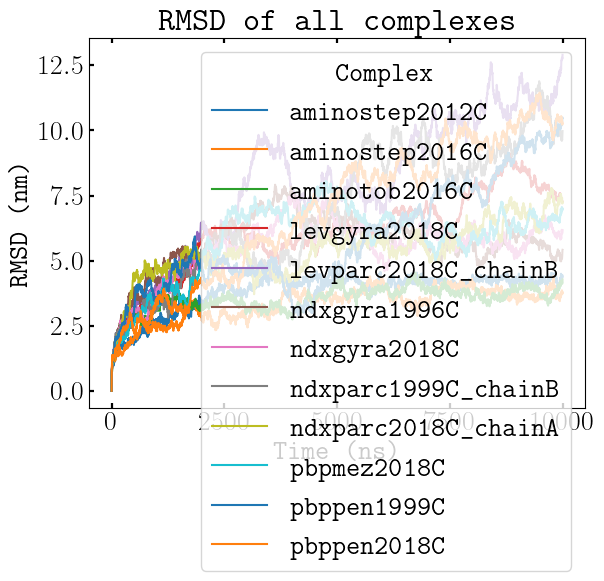

In [3]:
import pandas as pd
from MDAnalysis.analysis import rms
# Build the DataFrame directly by running the RMSD analysis for each complex
rmsd_df = None
for complexname, universe in tqdm(complexes.items()):
    R_local = rms.RMSD(universe, universe, select='backbone', ref_frame=0)
    R_local.run(verbose=False)
    times = R_local.results.rmsd[:, 1]
    rmsd = R_local.results.rmsd[:, 2]
    
    # For the first complex, initialize the DataFrame with the time column.
    if rmsd_df is None:
        rmsd_df = pd.DataFrame({'Time': times})
        
    # Add the RMSD values for the current complex to the DataFrame.
    rmsd_df[complexname] = rmsd

# Prepare and display the plot.
rmsd_df.set_index('Time', inplace=True)
rmsd_df.plot()
plt.xlabel('Time (ns)')
plt.ylabel('RMSD (nm)')
plt.title('RMSD of all complexes')
plt.legend(title='Complex')
plt.show()


### Calculate all RMSF and load in a dataframe

In [4]:
import pandas as pd
from MDAnalysis.analysis import rms
# Build the DataFrame directly by running the RMSD analysis for each complex
rmsf_dict = {}
for complexname, universe in tqdm(complexes.items()):
    c_alphas_c = universe.select_atoms('backbone and name CA')
    R_c = rms.RMSF(c_alphas_c).run(verbose=False)
    resids = c_alphas_c.resids
    rmsf = R_c.results.rmsf
    rmsf_dict[f'{complexname}_resid'] = resids
    rmsf_dict[f'{complexname}_rmsf'] = rmsf


  0%|          | 0/12 [00:00<?, ?it/s]

### Calculate all Radii of Gyration and load in a dataframe 

  0%|          | 0/12 [00:00<?, ?it/s]

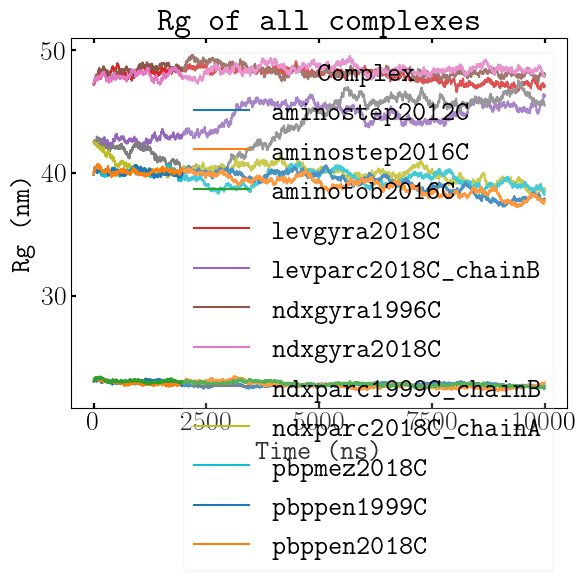

In [5]:
import pandas as pd
from MDAnalysis.analysis import rms
# Build the DataFrame directly by running the RMSD analysis for each complex
rg_df = None
for complexname, universe in tqdm(complexes.items()):
    group = universe.select_atoms('protein')
    times = []
    rg = []
    for ts in universe.trajectory:
        times.append(ts.time)
        rg.append(group.radius_of_gyration())
    # For the first complex, initialize the DataFrame with the time column.
    if rg_df is None:
        rg_df = pd.DataFrame({'Time': times})
        
    # Add the RMSD values for the current complex to the DataFrame.
    rg_df[complexname] = rg

# Prepare and display the plot.
rg_df.set_index('Time', inplace=True)
rg_df.plot()
plt.xlabel('Time (ns)')
plt.ylabel('Rg (nm)')
plt.title('Rg of all complexes')
lgd = plt.legend(title='Complex')
lgd.get_frame().set_alpha(0.2)
plt.show()

### Number of hydrogen bonds between protein and ligand

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

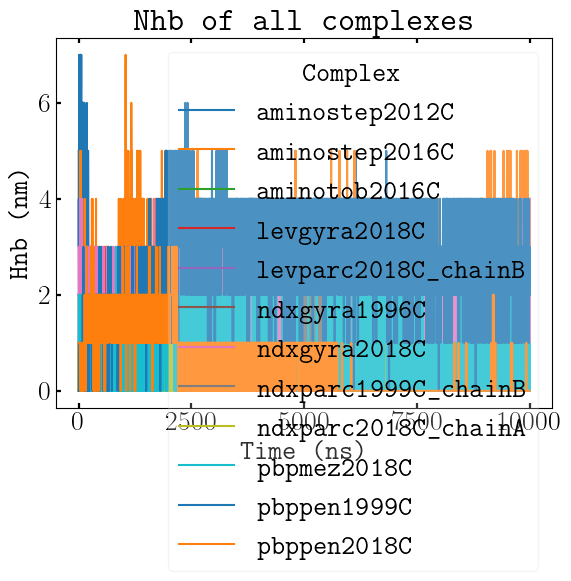

In [7]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
import numpy as np
import pandas as pd
hb_dict = {}
for complexname, universe in complexes.items():
    # Select the atoms for the analysis
    
    # Create the HydrogenBondAnalysis object
    hbs = HBA(universe=universe,
        update_selections=False
        )
    hbs.donors_sel = hbs.guess_donors("protein")
    hbs.hydrogens_sel = hbs.guess_hydrogens("protein")
    hbs.acceptors_sel = hbs.guess_acceptors("not protein")
    # Run the analysis
    
    hbs.run(verbose=True)
    ligand_indices = universe.select_atoms(hbs.acceptors_sel).indices    
    filtered_hbonds = []
    for hb in hbs.results.hbonds:
        frame, donor_idx, hydrogen_idx, acceptor_idx, da_dist, da_angle = hb
        if donor_idx not in ligand_indices and acceptor_idx in ligand_indices:
            filtered_hbonds.append(hb)
        if donor_idx in ligand_indices and acceptor_idx not in ligand_indices:
            filtered_hbonds.append(hb)
    hbs.results.hbonds = np.array(filtered_hbonds)

    hb_dict[complexname] = hbs

nhb_df = None
for complexname, hbs in hb_dict.items():
    times = hbs.times
    nhb = hbs.count_by_time()
    # For the first complex, initialize the DataFrame with the time column.
    if nhb_df is None:
        nhb_df = pd.DataFrame({'Time': times})
        
    # Add the RMSD values for the current complex to the DataFrame.
    nhb_df[complexname] = nhb
# Prepare and display the plot.
# Prepare and display the plot.
nhb_df.set_index('Time', inplace=True)
nhb_df.plot()
plt.xlabel('Time (ns)')
plt.ylabel('Hnb (nm)')
plt.title('Nhb of all complexes')
lgd = plt.legend(title='Complex')
lgd.get_frame().set_alpha(0.2)
plt.show()

### Plot everything

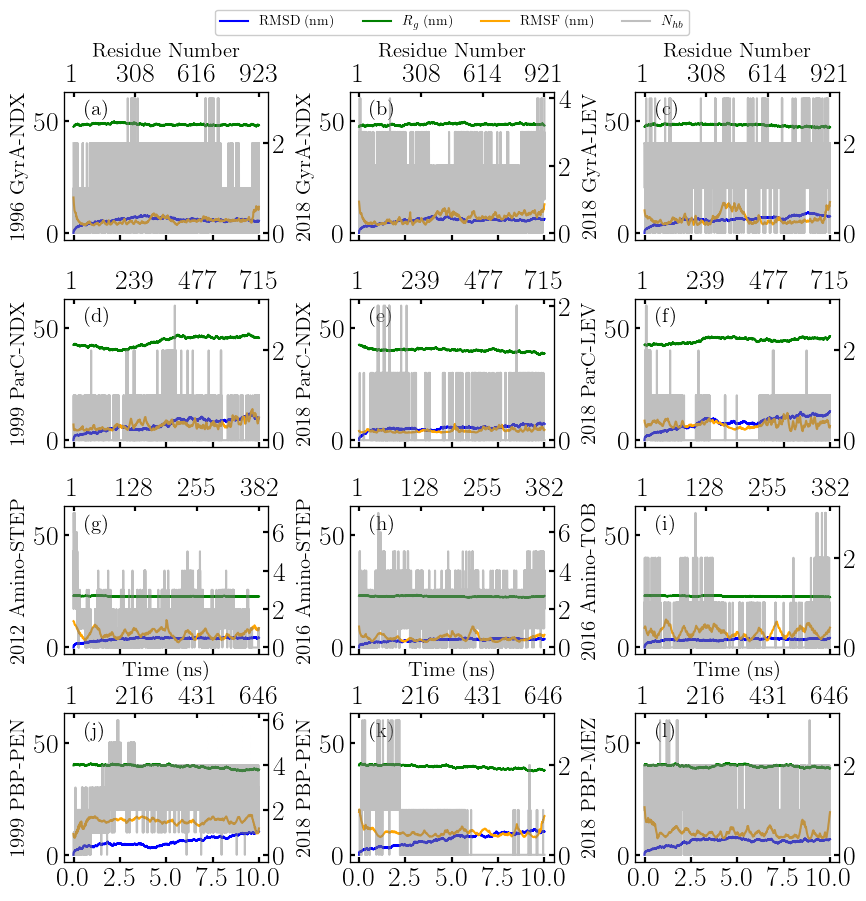

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

matplotlib.rcParams['axes.titlepad'] = 0
# Override the behavior of ax.axis('off') so that calls to turn off axes are ignored.
import matplotlib.axes as maxes
matplotlib.rcParams.update({'font.family': 'Times New Roman'})
_original_axis = maxes.Axes.axis

def new_axis(self, *args, **kwargs):
    if args and args[0] == 'off':
        return self  # Skip turning off the axes
    return _original_axis(self, *args, **kwargs)

maxes.Axes.axis = new_axis

def add_plot(complexname, dataframe, axis, top_dict, right_df ,legend=False, topxlabel=False, bottomxlabel=False):
    axis.plot(dataframe.index/1000, dataframe[complexname], label="RMSD (nm)", color='blue')
    axis.plot(rg_df.index/1000, rg_df[complexname], label=r"$R_g$ (nm)", color='green')
    axis.set_xticks(dataframe.index[::int(len(dataframe)/4)]/1000)
    axis.set_xticklabels(dataframe.index[::int(len(dataframe)/4)]/1000)
    
    ax_top = axis.twiny()
    
    ax_top.plot(top_dict[f"{complexname}_resid"], top_dict[f"{complexname}_rmsf"], label="RMSF (nm)", color='orange')
    ticks = np.linspace(top_dict[f"{complexname}_resid"][0], top_dict[f"{complexname}_resid"][-1], 4)
    ax_top.set_xticks(ticks)
    ax_top.set_xticklabels(["{:.0f}".format(x) for x in ticks])

    ax_right = axis.twinx()
    ax_right.plot(right_df.index/1000, right_df[complexname], label=r"$N_{hb}$", color='gray', alpha=0.5)
    ymin, ymax = ax_right.get_ylim()
    ticks = np.arange(0, np.ceil(ymax),2)
    ax_right.set_yticks(ticks)
    ax_right.set_yticklabels(["{:.0f}".format(x) for x in ticks])

    if legend:
        lines, labels = axis.get_legend_handles_labels()
        top_lines, top_labels = ax_top.get_legend_handles_labels()
        right_lines, right_labels = ax_right.get_legend_handles_labels()
        axis.legend(lines + top_lines + right_lines, labels + top_labels + right_labels, 
                    loc='upper center', fontsize=10, title_fontsize=10, ncol=4)
        
        lgd = axis.get_legend()
        lgd.set_bbox_to_anchor((0.5, 1.6))
        lgd.get_frame().set_alpha(1.0)
        

    if topxlabel:
        ax_top.set_xlabel('Residue Number', fontsize=15)
    if bottomxlabel:
        axis.set_xlabel('Time (ns)', fontsize=15)    

# Define a 5x3 grid with custom spacing between subplots
fig, axs = plt.subplots(4, 3, figsize=(10, 10), gridspec_kw={'wspace': 0.4, 'hspace': 0.4}, sharex=True, sharey=False)

# Add subplots at specific grid positions
# For example, here we place one subplot per grid cell in a manner that mimics your layout.
ax_ndxgyra1996  = axs[0, 0]
add_plot('ndxgyra1996C', rmsd_df, ax_ndxgyra1996, rmsf_dict,nhb_df, topxlabel=True)
ax_ndxgyra1996.set_ylabel('1996 GyrA-NDX', fontsize=15)

ax_ndxgyra2018  = axs[0, 1]
add_plot('ndxgyra2018C', rmsd_df, ax_ndxgyra2018, rmsf_dict, nhb_df, topxlabel=True, legend=True)
ax_ndxgyra2018.set_ylabel('2018 GyrA-NDX', fontsize=15)

ax_levgyra2018  = axs[0,2]
add_plot('levgyra2018C', rmsd_df, ax_levgyra2018, rmsf_dict, nhb_df, topxlabel=True)
ax_levgyra2018.set_ylabel('2018 GyrA-LEV', fontsize=15)


ax_ndxparc1999  = axs[1,0]
add_plot('ndxparc1999C_chainB', rmsd_df, ax_ndxparc1999, rmsf_dict, nhb_df)
ax_ndxparc1999.set_ylabel('1999 ParC-NDX', fontsize=15)

ax_ndxparc2018  = axs[1,1]
add_plot('ndxparc2018C_chainA', rmsd_df, ax_ndxparc2018, rmsf_dict, nhb_df)
ax_ndxparc2018.set_ylabel('2018 ParC-NDX', fontsize=15)

ax_levparc2018  = axs[1,2]
add_plot('levparc2018C_chainB', rmsd_df, ax_levparc2018, rmsf_dict, nhb_df)
ax_levparc2018.set_ylabel('2018 ParC-LEV', fontsize=15)

ax_aminostep2012  = axs[2,0]
add_plot('aminostep2012C', rmsd_df, ax_aminostep2012, rmsf_dict, nhb_df, bottomxlabel=True)
ax_aminostep2012.set_ylabel('2012 Amino-STEP', fontsize=15)

ax_aminostep2016  = axs[2,1]
add_plot('aminostep2016C', rmsd_df, ax_aminostep2016, rmsf_dict, nhb_df, bottomxlabel=True)
ax_aminostep2016.set_ylabel('2016 Amino-STEP', fontsize=15)

ax_aminotob2016  = axs[2,2]
add_plot('aminotob2016C', rmsd_df, ax_aminotob2016, rmsf_dict, nhb_df, bottomxlabel=True)
ax_aminotob2016.set_ylabel('2016 Amino-TOB', fontsize=15)

ax_pbppen1999  = axs[3,0]
add_plot('pbppen1999C', rmsd_df, ax_pbppen1999, rmsf_dict, nhb_df)
ax_pbppen1999.set_ylabel('1999 PBP-PEN', fontsize=15)

ax_pbppen2018  = axs[3,1]
add_plot('pbppen2018C', rmsd_df, ax_pbppen2018, rmsf_dict, nhb_df)
ax_pbppen2018.set_ylabel('2018 PBP-PEN', fontsize=15)

ax_pbpmez2018  = axs[3,2]
add_plot('pbpmez2018C', rmsd_df, ax_pbpmez2018, rmsf_dict, nhb_df)
ax_pbpmez2018.set_ylabel('2018 PBP-MEZ', fontsize=15)


labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)']
for ax, label in zip(axs.flatten(), labels):
    ax.text(0.1, 0.95, label, transform=ax.transAxes,
            fontsize=15, fontweight='bold', va='top', ha='left')

for axis in axs.flatten():
    axis.set_ylim(-3, 63)

plt.savefig("Pseudomonas_antibiotics.svg", dpi=300)
plt.savefig("Pseudomonas_antibiotics.png", dpi=300)
plt.show()

### Hydrogen Bond occupancy statistics

In [9]:
from tqdm.notebook import tqdm
hb_details = {}

for complex, hb in tqdm(hb_dict.items()):
    u = complexes[complex]
    ligand_indices = u.select_atoms(hb.acceptors_sel).indices
    hbstats = hb.count_by_ids()
    # Only keep bonds with occupancy more than 5%
    hbstats_filtered = hbstats[hbstats[:, -1] / hb.n_frames > 0.04]
    bond_types = []
    for bond in hbstats_filtered:
        donor_idx, hydrogen_idx, acceptor_idx, occ = bond
        donor_atom = u.atoms[int(donor_idx)]
        hydrogen_atom = u.atoms[int(hydrogen_idx)]
        acceptor_atom = u.atoms[int(acceptor_idx)]
        # Check if the donor or acceptor is a ligand
        if donor_idx in ligand_indices and acceptor_idx not in ligand_indices:
            # Donor is a ligand, acceptor is not
            bond_type = f"({donor_atom.resname}){donor_atom.name}-H::{acceptor_atom.name}({acceptor_atom.resid}-{acceptor_atom.resname}) : {occ/hb.n_frames:.2f}"
        elif acceptor_idx in ligand_indices and donor_idx not in ligand_indices:
            # Acceptor is a ligand, donor is not
            bond_type = f"({donor_atom.resid}-{donor_atom.resname}){donor_atom.name}-H::{acceptor_atom.name}({acceptor_atom.resname}) : {occ/hb.n_frames:.2f}"
        else:
            # Both donor and acceptor are ligands
            continue
        bond_types.append(bond_type)
    
    hb_details[complex] = bond_types

  0%|          | 0/12 [00:00<?, ?it/s]

### Plot everything

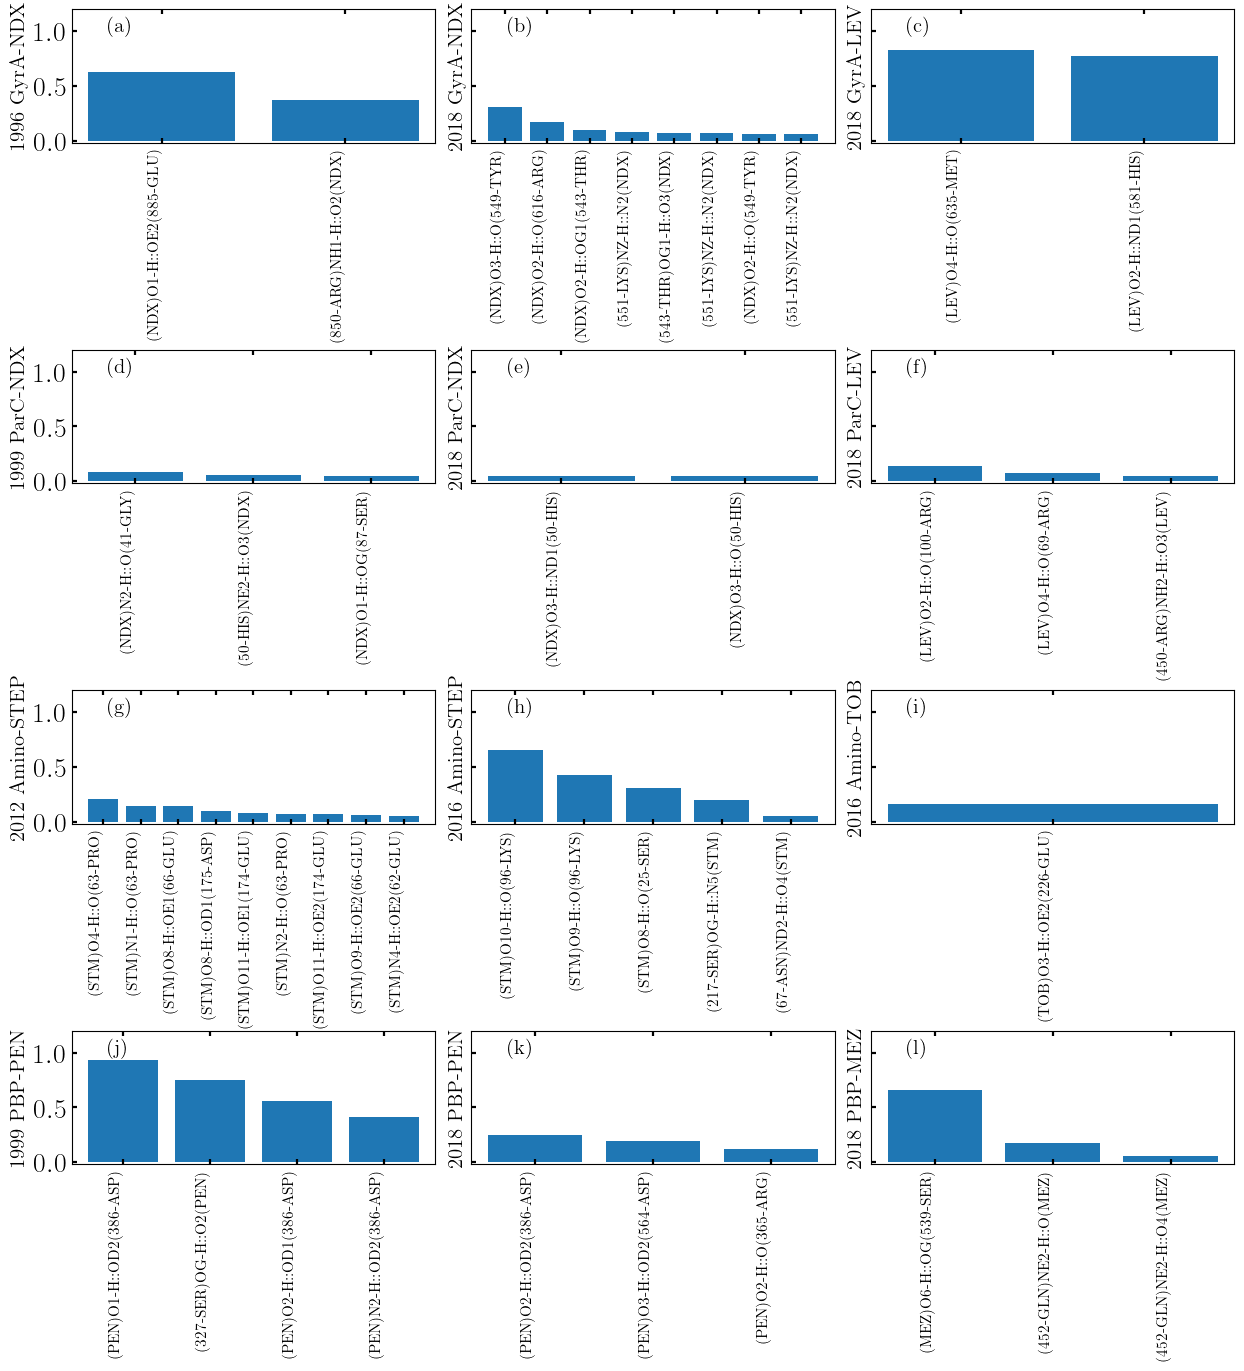

In [27]:
import matplotlib.pyplot as plt

def add_hist(complexname, bond_types, ax):
    # Parse the bond_types to extract bond labels and occupancy values
    labels = [b.split(" : ")[0] for b in bond_types]
    occupancies = [float(b.split(" : ")[1]) for b in bond_types]

    ax.bar(range(len(occupancies)), np.array(occupancies))
    ax.set_xticks(range(len(occupancies)), labels, rotation=90, ha='right', fontsize=11)
    #ax.set_ylabel(complexname.replace("C", "").replace('_', '-'), fontsize=12)
    ax.set_ylim(-0.02, 1.2)
    ax.set_yticks(np.linspace(0, 1, 3))

# Define a 5x3 grid with custom spacing between subplots
fig, axs = plt.subplots(4, 3, figsize=(15, 15), gridspec_kw={'wspace': 0.1, 'hspace': 1.55}, sharey=True)

# Add subplots at specific grid positions
# For example, here we place one subplot per grid cell in a manner that mimics your layout.
ax_ndxgyra1996  = axs[0, 0]
add_hist('ndxgyra1996C', hb_details['ndxgyra1996C'], ax_ndxgyra1996)
ax_ndxgyra1996.set_ylabel('1996 GyrA-NDX', fontsize=15)

ax_ndxparc1999  = axs[1,0]
add_hist('ndxparc1999C_chainB', hb_details['ndxparc1999C_chainB'], ax_ndxparc1999)
ax_ndxparc1999.set_ylabel('1999 ParC-NDX', fontsize=15)

ax_pbppen1999  = axs[3,0]
add_hist('pbppen1999C', hb_details['pbppen1999C'], ax_pbppen1999)
ax_pbppen1999.set_ylabel('1999 PBP-PEN', fontsize=15)

ax_aminostep2012  = axs[2,0]
add_hist('aminostep2012C', hb_details['aminostep2012C'], ax_aminostep2012)
ax_aminostep2012.set_ylabel('2012 Amino-STEP', fontsize=15)

ax_aminostep2016  = axs[2,1]
add_hist('aminostep2016C', hb_details['aminostep2016C'], ax_aminostep2016)
ax_aminostep2016.set_ylabel('2016 Amino-STEP', fontsize=15)

ax_aminotob2016  = axs[2,2]
add_hist('aminotob2016C', hb_details['aminotob2016C'], ax_aminotob2016)
ax_aminotob2016.set_ylabel('2016 Amino-TOB', fontsize=15)


ax_levgyra2018  = axs[0,2]
add_hist('levgyra2018C', hb_details['levgyra2018C'], ax_levgyra2018)
ax_levgyra2018.set_ylabel('2018 GyrA-LEV', fontsize=15)

ax_ndxgyra2018  = axs[0,1]
add_hist('ndxgyra2018C', hb_details['ndxgyra2018C'], ax_ndxgyra2018)
ax_ndxgyra2018.set_ylabel('2018 GyrA-NDX', fontsize=15)

ax_levparc2018  = axs[1,2]
add_hist('levparc2018C_chainB', hb_details['levparc2018C_chainB'], ax_levparc2018)
ax_levparc2018.set_ylabel('2018 ParC-LEV', fontsize=15)

ax_ndxparc2018  = axs[1,1]
add_hist('ndxparc2018C_chainA', hb_details['ndxparc2018C_chainA'], ax_ndxparc2018)
ax_ndxparc2018.set_ylabel('2018 ParC-NDX', fontsize=15)

ax_pbpmez2018  = axs[3,2]
add_hist('pbpmez2018C', hb_details['pbpmez2018C'], ax_pbpmez2018)
ax_pbpmez2018.set_ylabel('2018 PBP-MEZ', fontsize=15)


ax_pbppen2018  = axs[3,1]
add_hist('pbppen2018C', hb_details['pbppen2018C'], ax_pbppen2018)
ax_pbppen2018.set_ylabel('2018 PBP-PEN', fontsize=15)

labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)']
for ax, label in zip(axs.flatten(), labels):
    ax.text(0.1, 0.95, label, transform=ax.transAxes,
            fontsize=15, fontweight='bold', va='top', ha='left')
plt.savefig("Pseudomonas_antibiotics_hbonds.svg", dpi=300)
plt.savefig("Pseudomonas_antibiotics_hbonds.png", dpi=300)
plt.show()

## New Layout

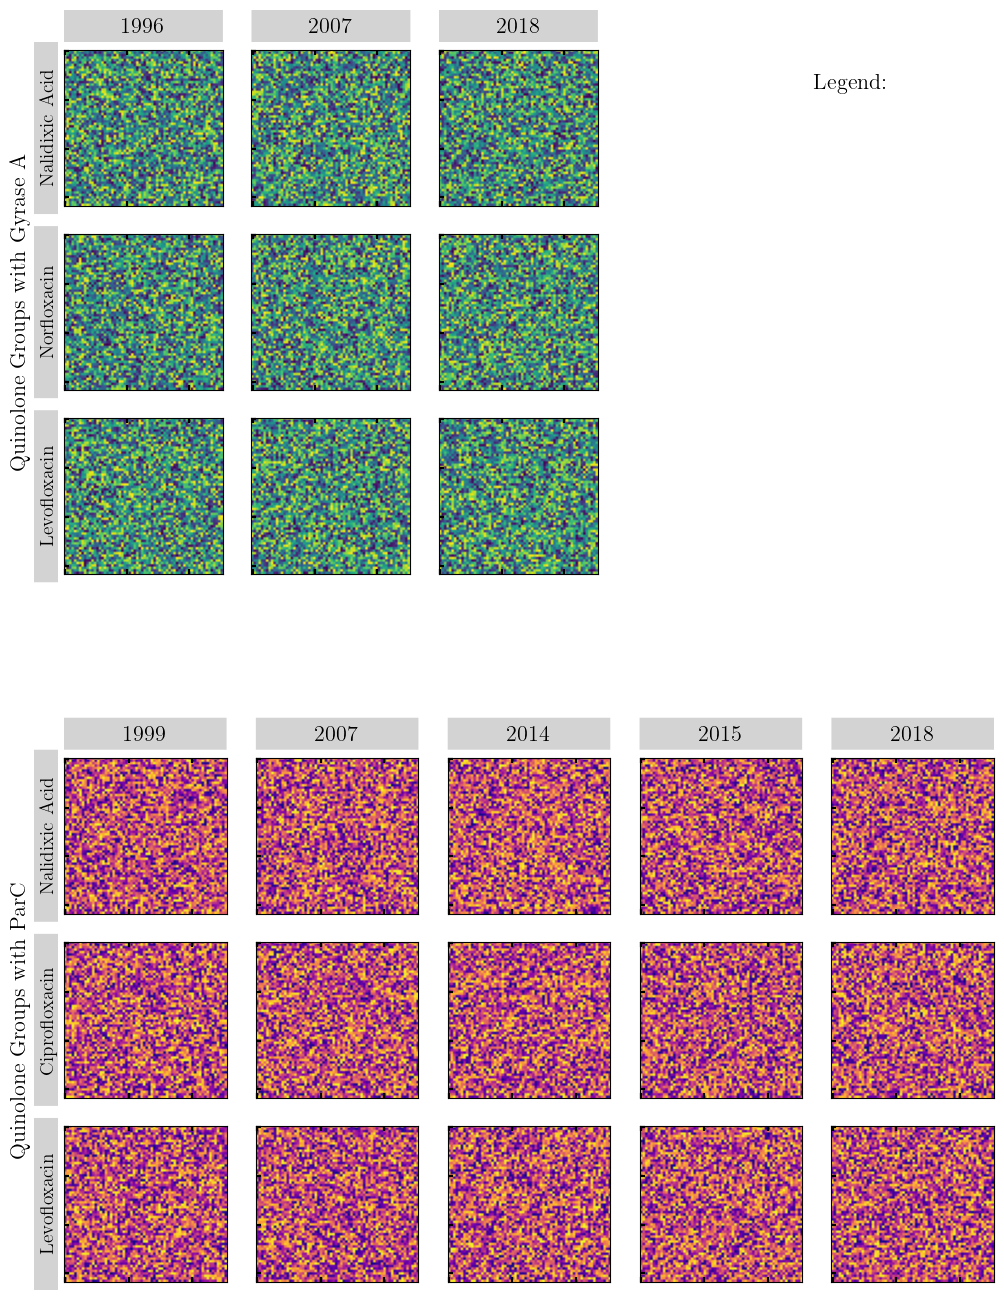

In [97]:
# language: python
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Carlito'
mpl.rcParams['font.serif'] = ['Carlito']
mpl.rcParams['font.size'] = 12
mpl.rcParams['mathtext.fontset'] = 'stix'
from matplotlib.patches import FancyBboxPatch

fig = plt.figure(figsize=(12, 16))
# Outer: left main area + right legend column
outer = GridSpec(nrows=1, ncols=2, width_ratios=[8, 2], wspace=0.06)

# Left area subdivided into top and bottom blocks
left_blocks = outer[0, 0].subgridspec(nrows=2, ncols=4, height_ratios=[1, 1], hspace=0.35)


# Top block: 3 rows × 3 cols
top_gs = left_blocks[0,0:3].subgridspec(nrows=3, ncols=3, hspace=0.18, wspace=0.18)
top_axes = [[fig.add_subplot(top_gs[r, c]) for c in range(3)] for r in range(3)]

# Bottom block: 3 rows × 5 cols
# make the bottom block span the full figure width (both left and legend columns)
left_blocks = outer[0, :].subgridspec(nrows=2, ncols=1, height_ratios=[1, 1], hspace=0.35)
bot_gs = left_blocks[1].subgridspec(nrows=3, ncols=5, hspace=0.18, wspace=0.18)
bot_axes = [[fig.add_subplot(bot_gs[r, c]) for c in range(5)] for r in range(3)]

# Right legend / annotation column
legend_ax = fig.add_subplot(outer[0, 1])
legend_ax.axis('off')
legend_ax.text(0.0, 0.98, "Legend:", va='top', fontsize=16, weight='bold')

# Fill panels with placeholder content and hide axes ticks
for r in range(3):
    for c in range(3):
        ax = top_axes[r][c]
        ax.imshow(np.random.rand(64, 64), cmap='viridis', aspect='auto')
        #ax.axis('off')
        # hide axis label text (tick labels) but keep tick marks
        ax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)

for r in range(3):
    for c in range(5):
        ax = bot_axes[r][c]
        ax.imshow(np.random.rand(64, 64), cmap='plasma', aspect='auto')
        #ax.axis('off')
        # hide axis label text (tick labels) but keep tick marks
        ax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)

# Column headers for top block
top_years = ['1996', '2007', '2018']
for j, year in enumerate(top_years):
    pos = top_axes[0][j].get_position()
    cx = pos.x0 + pos.width / 2
    cy = pos.y1 + 0.008
    bb = FancyBboxPatch((pos.x0, cy-0.003), pos.width, 0.02,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(cx, cy, year, ha='center', va='bottom', fontsize=16, weight='bold')

# Column headers for bottom block
bot_years = ['1999', '2007', '2014', '2015', '2018']
for j, year in enumerate(bot_years):
    pos = bot_axes[0][j].get_position()
    cx = pos.x0 + pos.width / 2
    cy = pos.y1 + 0.008
    bb = FancyBboxPatch((pos.x0, cy-0.003), pos.width, 0.02,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(cx, cy, year, ha='center', va='bottom', fontsize=16, weight='bold')

# Vertical group labels (left side)
top_block_pos = top_axes[1][0].get_position()  # middle row of top block
bot_block_pos = bot_axes[1][0].get_position()  # middle row of bottom block
# compute vertical centers from actual axes positions (fixes AttributeError)
top_positions = [top_axes[r][c].get_position() for r in range(len(top_axes)) for c in range(len(top_axes[0]))]
top_y0 = min(p.y0 for p in top_positions)
top_y1 = max(p.y1 for p in top_positions)
top_center = (top_y0 + top_y1) / 2

bot_positions = [bot_axes[r][c].get_position() for r in range(len(bot_axes)) for c in range(len(bot_axes[0]))]
bot_y0 = min(p.y0 for p in bot_positions)
bot_y1 = max(p.y1 for p in bot_positions)
bot_center = (bot_y0 + bot_y1) / 2

fig.text(0.08, top_center, "Quinolone Groups with Gyrase A",
        va='center', ha='left', rotation=90, fontsize=16, weight='bold')
fig.text(0.08, bot_center, "Quinolone Groups with ParC",
        va='center', ha='left', rotation=90, fontsize=16, weight='bold')

Ligand_names = ["Nalidixic Acid", "Norfloxacin", "Levofloxacin"]

for i, name in enumerate(Ligand_names):
    pos = top_axes[i][0].get_position()
    # Create a background box for the ylabel
    ylab_box = FancyBboxPatch(
        (pos.x0 - 0.025, pos.y0 - 0.005),        # slightly lower so it doesn't overlap the label
        0.02,
        pos.height + 0.01,                      # a hair taller to sit nicely behind the label
        boxstyle="round,pad=0.0",
        transform=fig.transFigure,
        facecolor="lightgray",
        edgecolor="k",
        linewidth=0,
        zorder=0                                 # draw underneath the axis label text
    )
    fig.add_artist(ylab_box)
    bb = FancyBboxPatch((pos.x0-0.025, pos.y0), 0.02, pos.height,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(pos.x0 - 0.02, pos.y0 + pos.height / 2, name,
            va='center', ha='left', rotation=90, fontsize=14)


Ligand_names = ["Nalidixic Acid", "Ciprofloxacin", "Levofloxacin"]
for i, name in enumerate(Ligand_names):
    pos = bot_axes[i][0].get_position()
    # Create a background box for the ylabel
    ylab_box = FancyBboxPatch(
        (pos.x0 - 0.025, pos.y0 - 0.005),        # slightly lower so it doesn't overlap the label
        0.02,
        pos.height + 0.01,                      # a hair taller to sit nicely behind the label
        boxstyle="round,pad=0.0",
        transform=fig.transFigure,
        facecolor="lightgray",
        edgecolor="k",
        linewidth=0,
        zorder=0                                 # draw underneath the axis label text
    )
    fig.add_artist(ylab_box)
    bb = FancyBboxPatch((pos.x0-0.025, pos.y0), 0.02, pos.height,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(pos.x0 - 0.02, pos.y0 + pos.height / 2, name,
            va='center', ha='left', rotation=90, fontsize=14)

#plt.savefig("layout_example.png", dpi=300, bbox_inches='tight')
plt.show()

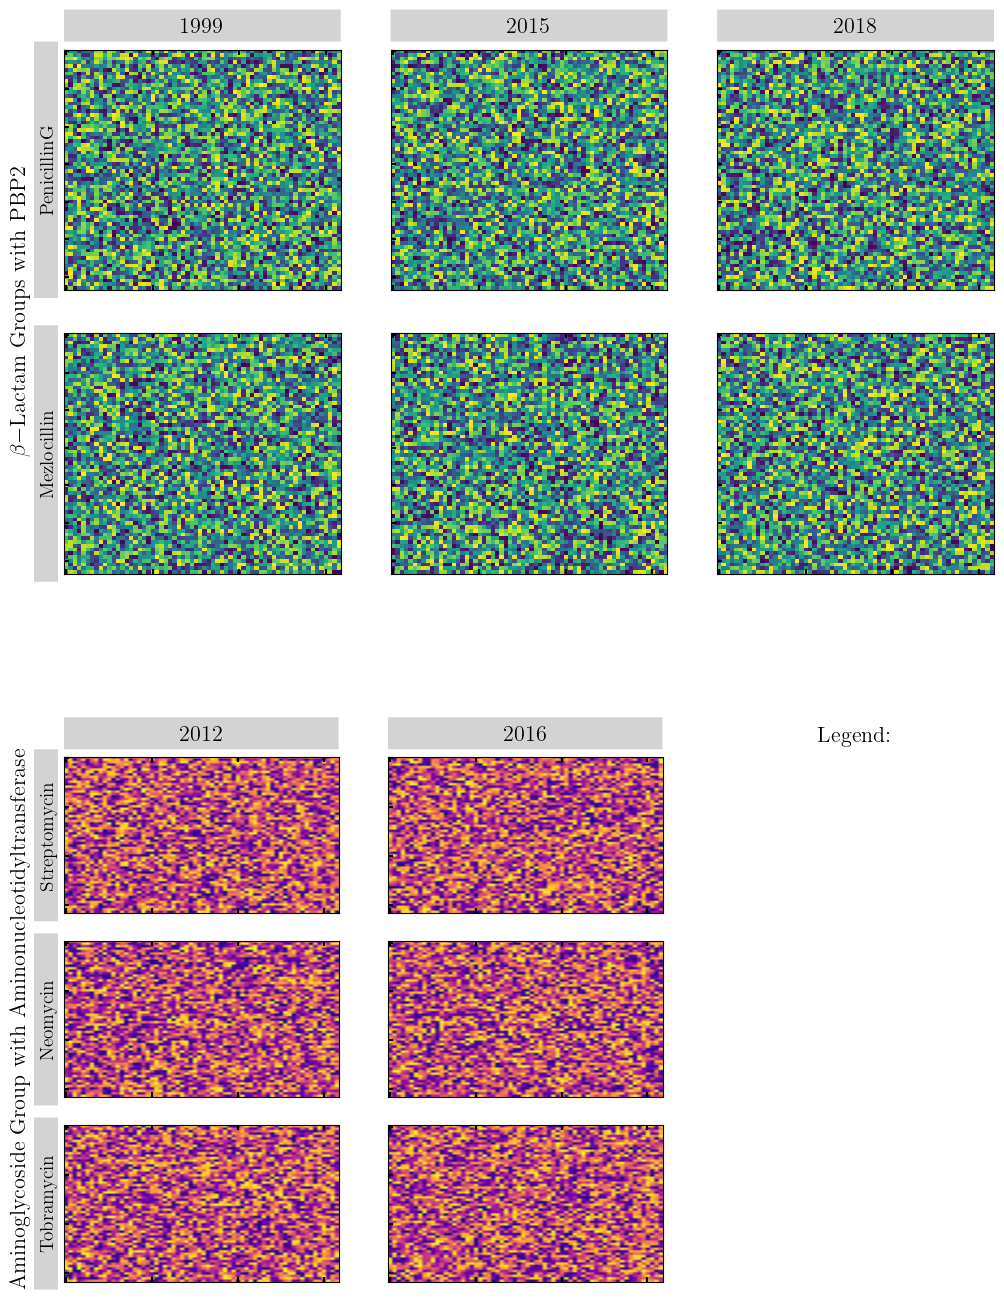

In [99]:
# language: python

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Carlito'
mpl.rcParams['font.serif'] = ['Carlito']
mpl.rcParams['font.size'] = 12
mpl.rcParams['mathtext.fontset'] = 'stix'
from matplotlib.patches import FancyBboxPatch

fig = plt.figure(figsize=(12, 16))
# Outer: left main area + right legend column
outer = GridSpec(nrows=1, ncols=2, width_ratios=[8, 2], wspace=0.06)

# Left area subdivided into top and bottom blocks
left_blocks = outer[0, :].subgridspec(nrows=2, ncols=1, height_ratios=[1, 1], hspace=0.35)

# Top block: 2 rows × 3 cols
top_gs = left_blocks[0].subgridspec(nrows=2, ncols=3, hspace=0.18, wspace=0.18)
top_axes = [[fig.add_subplot(top_gs[r, c]) for c in range(3)] for r in range(2)]


# Bottom block: 3 rows × 2 cols
left_blocks = outer[0, 0].subgridspec(nrows=2, ncols=6, height_ratios=[1, 1], hspace=0.35)
bot_gs = left_blocks[1,0:5].subgridspec(nrows=3, ncols=2, hspace=0.18, wspace=0.18)
bot_axes = [[fig.add_subplot(bot_gs[r, c]) for c in range(2)] for r in range(3)]

# Right legend / annotation column
legend_ax = fig.add_subplot(outer[0, 1])
legend_ax.axis('off')
legend_ax.text(0.02, 0.45, "Legend:", va='top', fontsize=16, weight='bold')

# Fill panels with placeholder content and hide axes ticks
for r in range(2):
    for c in range(3):
        ax = top_axes[r][c]
        ax.imshow(np.random.rand(64, 64), cmap='viridis', aspect='auto')
        #ax.axis('off')
        # hide axis label text (tick labels) but keep tick marks
        ax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)

for r in range(3):
    for c in range(2):
        ax = bot_axes[r][c]
        ax.imshow(np.random.rand(64, 64), cmap='plasma', aspect='auto')
        #ax.axis('off')
        # hide axis label text (tick labels) but keep tick marks
        ax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)

# Column headers for top block
top_years = ['1999', '2015', '2018']
for j, year in enumerate(top_years):
    pos = top_axes[0][j].get_position()
    cx = pos.x0 + pos.width / 2
    cy = pos.y1 + 0.008
    bb = FancyBboxPatch((pos.x0, cy-0.003), pos.width, 0.02,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(cx, cy, year, ha='center', va='bottom', fontsize=16, weight='bold')

# Column headers for bottom block
bot_years = ['2012','2016']
for j, year in enumerate(bot_years):
    pos = bot_axes[0][j].get_position()
    cx = pos.x0 + pos.width / 2
    cy = pos.y1 + 0.008
    bb = FancyBboxPatch((pos.x0, cy-0.003), pos.width, 0.02,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(cx, cy, year, ha='center', va='bottom', fontsize=16, weight='bold')

# Vertical group labels (left side)
top_block_pos = top_axes[1][0].get_position()  # middle row of top block
bot_block_pos = bot_axes[1][0].get_position()  # middle row of bottom block
# compute vertical centers from actual axes positions (fixes AttributeError)
top_positions = [top_axes[r][c].get_position() for r in range(len(top_axes)) for c in range(len(top_axes[0]))]
top_y0 = min(p.y0 for p in top_positions)
top_y1 = max(p.y1 for p in top_positions)
top_center = (top_y0 + top_y1) / 2

bot_positions = [bot_axes[r][c].get_position() for r in range(len(bot_axes)) for c in range(len(bot_axes[0]))]
bot_y0 = min(p.y0 for p in bot_positions)
bot_y1 = max(p.y1 for p in bot_positions)
bot_center = (bot_y0 + bot_y1) / 2

fig.text(0.08, top_center, r"$\beta -$Lactam Groups with PBP2",
        va='center', ha='left', rotation=90, fontsize=16, weight='bold')
fig.text(0.08, bot_center, "Aminoglycoside Group with Aminonucleotidyltransferase",
        va='center', ha='left', rotation=90, fontsize=16, weight='bold')

Ligand_names = ["PenicillinG", "Mezlocillin"]
for i, name in enumerate(Ligand_names):
    pos = top_axes[i][0].get_position()
    # Create a background box for the ylabel
    ylab_box = FancyBboxPatch(
        (pos.x0 - 0.025, pos.y0 - 0.005),        # slightly lower so it doesn't overlap the label
        0.02,
        pos.height + 0.01,                      # a hair taller to sit nicely behind the label
        boxstyle="round,pad=0.0",
        transform=fig.transFigure,
        facecolor="lightgray",
        edgecolor="k",
        linewidth=0,
        zorder=0                                 # draw underneath the axis label text
    )
    fig.add_artist(ylab_box)
    bb = FancyBboxPatch((pos.x0-0.025, pos.y0), 0.02, pos.height,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(pos.x0 - 0.02, pos.y0 + pos.height / 2, name,
            va='center', ha='left', rotation=90, fontsize=14)


Ligand_names = ["Streptomycin", "Neomycin" , "Tobramycin"]
for i, name in enumerate(Ligand_names):
    pos = bot_axes[i][0].get_position()
    # Create a background box for the ylabel
    ylab_box = FancyBboxPatch(
        (pos.x0 - 0.025, pos.y0 - 0.005),        # slightly lower so it doesn't overlap the label
        0.02,
        pos.height + 0.01,                      # a hair taller to sit nicely behind the label
        boxstyle="round,pad=0.0",
        transform=fig.transFigure,
        facecolor="lightgray",
        edgecolor="k",
        linewidth=0,
        zorder=0                                 # draw underneath the axis label text
    )
    fig.add_artist(ylab_box)
    bb = FancyBboxPatch((pos.x0-0.025, pos.y0), 0.02, pos.height,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(pos.x0 - 0.02, pos.y0 + pos.height / 2, name,
            va='center', ha='left', rotation=90, fontsize=14)

#plt.savefig("layout_example.png", dpi=300, bbox_inches='tight')
plt.show()